In [1]:
import torch
import os.path as osp
from torch.utils.data import DataLoader
from utils.spikingjelly.spikingjelly.datasets.n_mnist import NMNIST
from utils.spikingjelly.spikingjelly.datasets import play_frame
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
from typing import cast
from utils.networks import STDPNet, DiehlAndCook2015, Mozafari2018
from utils.dataclasses import DistInfo, ExpInfo
from utils.trainer import train_Mozafari
from utils.visual import draw_weight_map

In [2]:
## Deprecated code for mnist
# FILE_LIST = "MNIST/raw/train-images-idx3-ubyte MNIST/raw/train-labels-idx1-ubyte MNIST/raw/t10k-images-idx3-ubyte MNIST/raw/t10k-labels-idx1-ubyte".split()
# arrays:list[np.ndarray] = []

# for fname in FILE_LIST:
#     with open(fname,'rb') as f:
#         arrays.append(mnist.parse_idx(f))
# assert len(arrays) == 4
# train_imgs, train_labels, test_imgs, test_labels = arrays

In [3]:
ExpInfo.use_cuda = True
w_min, w_max, w_mean, w_std = 0., 1., 0.5, 0.01
tau_pre, tau_post = 2., 2.
N_in, N_hidden, N_out = 2*34*34, 10, 10
T = 64
batch_size = 1
lr = 0.01

In [4]:
train_set = NMNIST("data/",train=True, data_type="frame", frames_number=T, split_by="number")
# test_set = NMNIST("data/",train=False, data_type="frame", frames_number=T, split_by="number")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

The directory [data/frames_number_64_split_by_number] already exists.


In [5]:
play_frame(train_set[15000][0], save_gif_to="data_sample.gif")

Save frames to [data_sample.gif].


In [6]:
if osp.isfile("saved.net"):
    with open("saved.net", 'rb') as f:
        M2018_state_dict = torch.load(f)

    net = Mozafari2018()
    net.load_state_dict(M2018_state_dict)

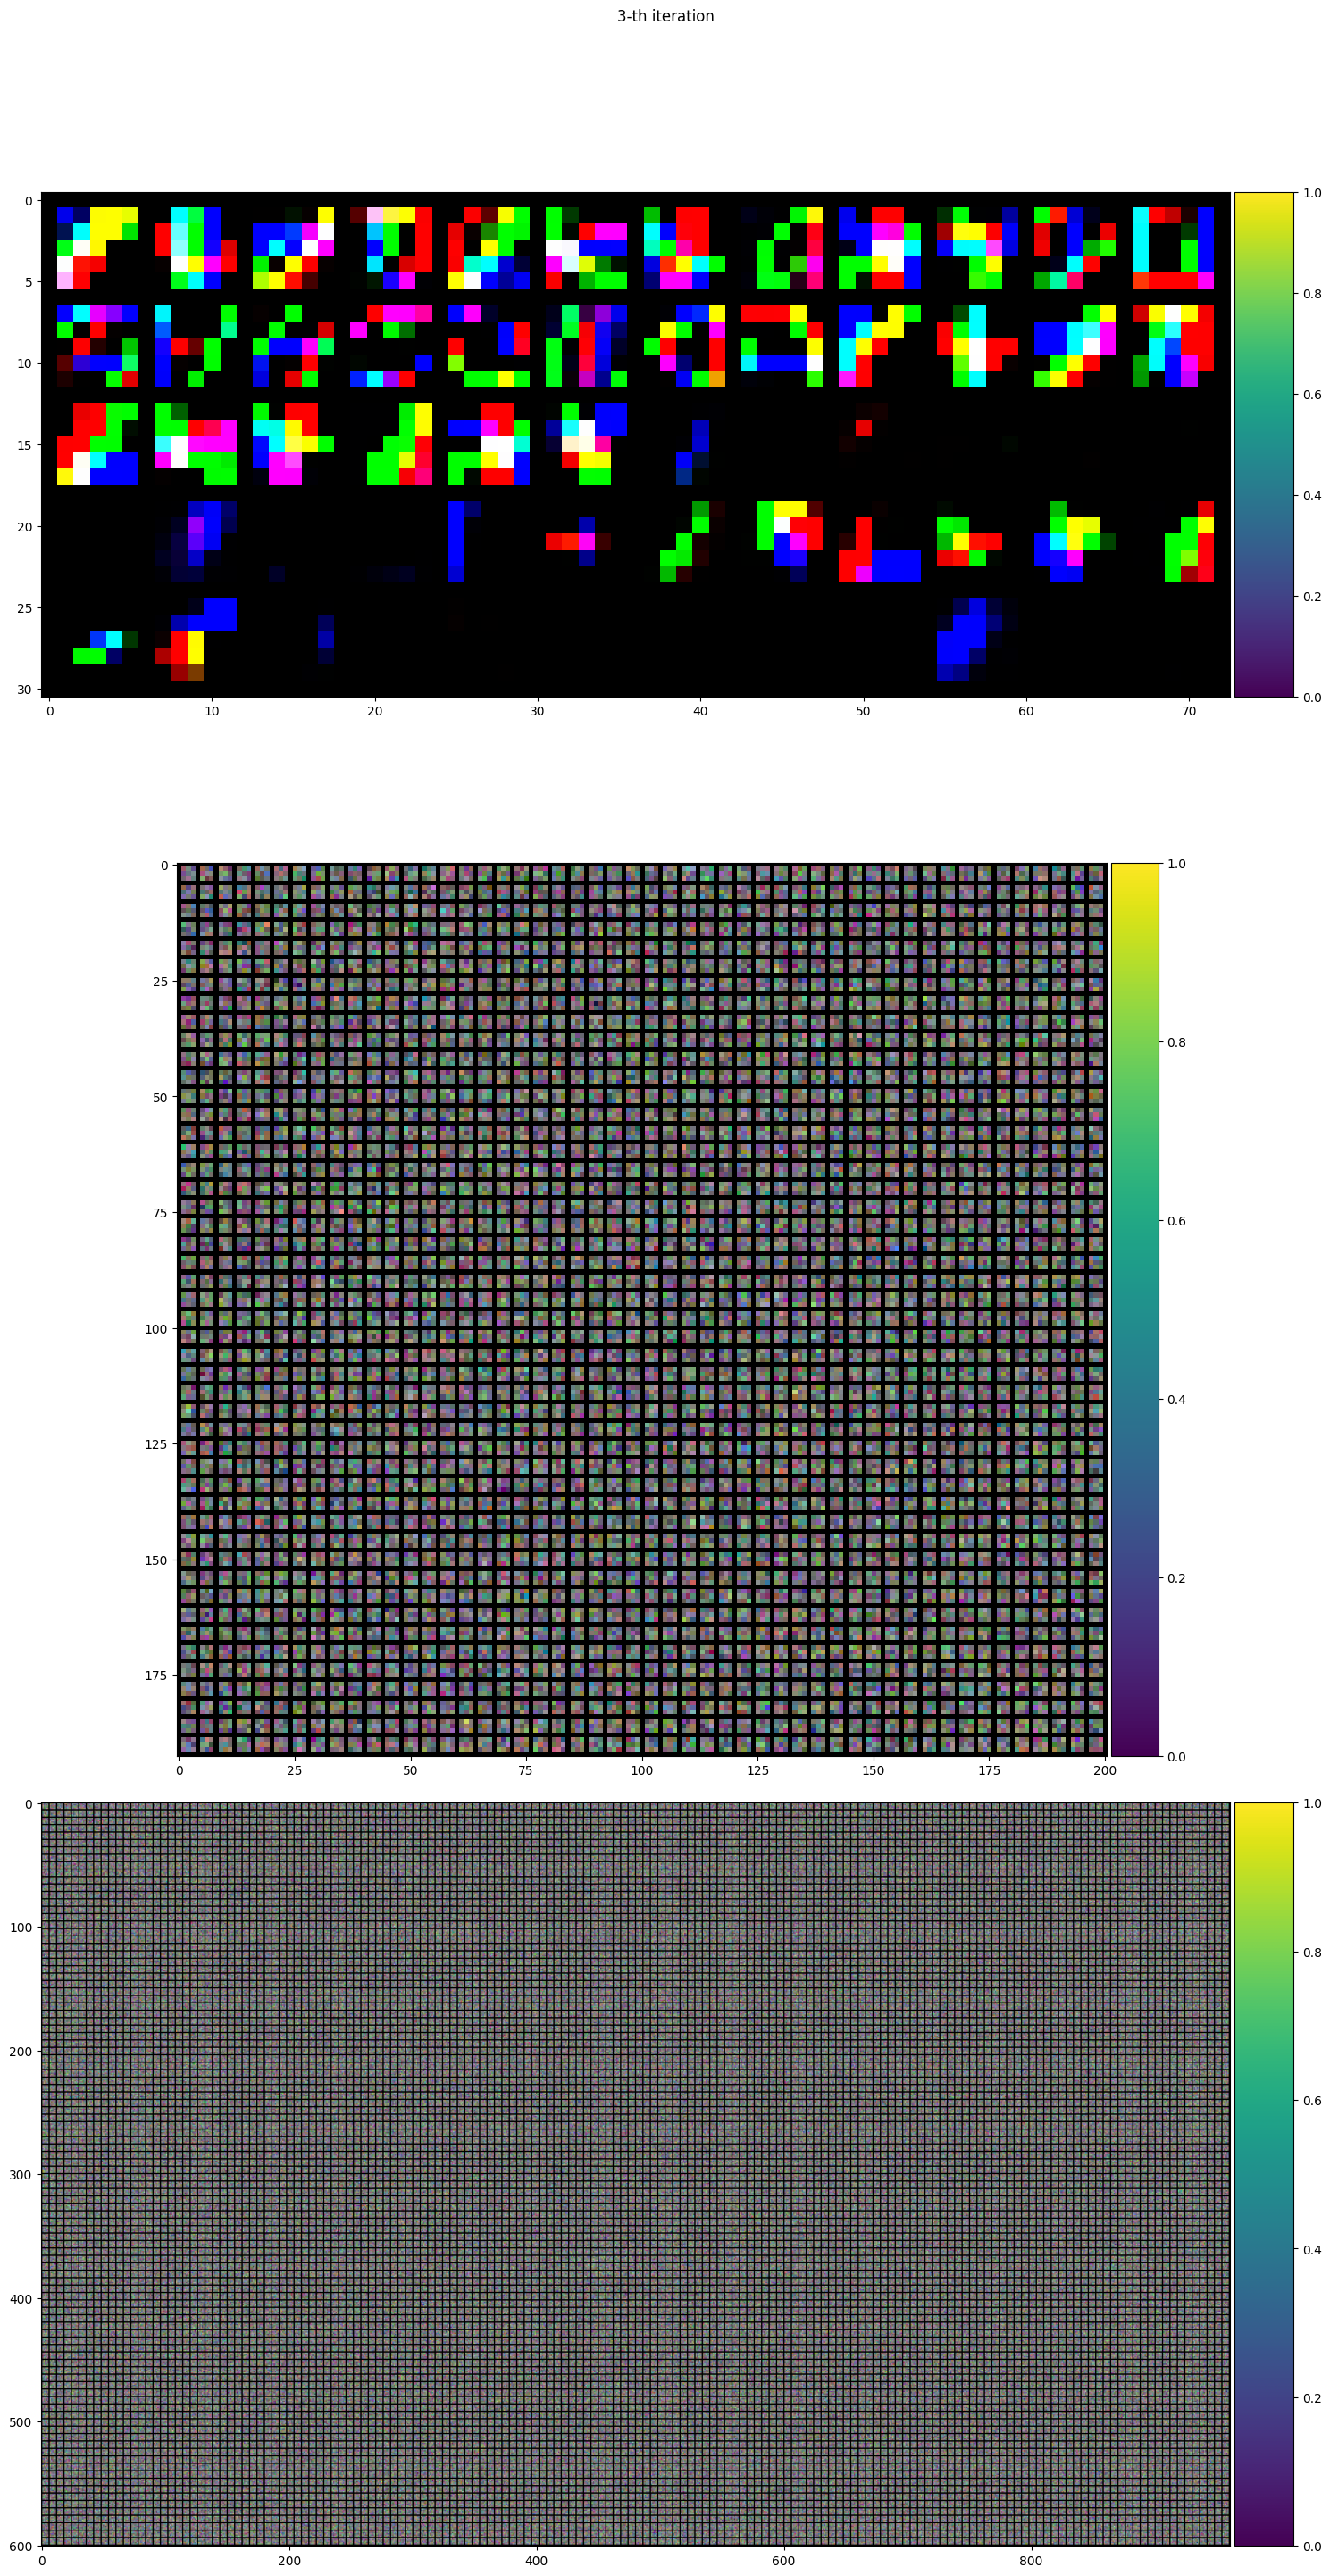

torch.Size([30, 6, 5, 5])
torch.Size([240, 30, 3, 3])
torch.Size([200, 240, 5, 5])
Training the first layer
Epoch 0
0
Iteration 0
Done!
1000
Iteration 1
Done!
2000
Iteration 2


In [ ]:
trainer = train_Mozafari()
fig, axes = plt.subplots(len(Mozafari2018.draw_ids),1)
fig.set_size_inches(30, 45)
fig.suptitle(f"0-th iteration")
d_handle = display(fig, display_id=True)
assert d_handle is not None

for step, ret in enumerate(trainer, start=1):
    for axe, img in zip(axes, ret):
        draw_weight_map(fig, axe, img)
    fig.suptitle(f"{step}-th iteration")
    fig.tight_layout()
    fig.savefig(f"out_img/{step:010d}.png")
    d_handle.update(fig)

In [ ]:
device = ["cpu", "cuda"][torch.cuda.is_available()]
torch.manual_seed(0)
do_train = False

# plt.style.use(['science'])

w_info = DistInfo(w_min, w_max, w_mean, w_std)
net:STDPNet = cast(STDPNet, DiehlAndCook2015(2*34*34, N_hidden, tau_pre, tau_post, w_info).to(device))

optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# Make figure to plot
fig = plt.figure(figsize=(15, 3*len(net.draw_ids)))
fig.suptitle(f"0-th iteration")

axes = []
caxes = []

# Subplot ops.
for i, draw_id in enumerate(net.draw_ids):
    axes.append(fig.add_subplot(len(net.draw_ids),1,i+1)) # generate new subplot.
    pc = axes[-1].pcolor(net.draw_weights(id=draw_id)) # make sub ax for color-number map.
    div = make_axes_locatable(axes[-1]) # get division of the subplot.
    caxes.append(div.append_axes("right", size="5%", pad=0.05)) # new ax for color bar
    fig.colorbar(pc, caxes[-1]) # make colorbar.
fig.tight_layout() # fit plots to layout
d_handle = display(fig, display_id=True) # jupyter display output
assert d_handle is not None # display handle must be valid.

with torch.no_grad():
    frame = torch.zeros((batch_size, 2*34, 34), requires_grad=False, device=device) # *2 for ON, OFF events
    loader = iter(train_loader)
    for i, (frames, label) in enumerate(loader, start=1):
        for t in range(T):
            assert frames.shape == (batch_size,64,2,34,34), f"{frames.shape}"
            optimizer.zero_grad()
            # out_spike.append(net(in_spike[t]))
            frame.fill_(0)
            frame[:,::2,:] = torch.tensor(frames[:,t,0])
            frame[:,1::2,:] = torch.tensor(frames[:,t,1])
            net(frame.reshape(batch_size,-1))
            
            for learner in net.learners:
                learner.step(on_grad=True)
            optimizer.step()
            net.post_optim()
            # weight.append(net[0].weight.data.clone())
            # trace_pre.append(learner.trace_pre)
            # trace_post.append(learner.trace_post)
        
        if i%10 == 0:
            fig.suptitle(f"{i}-th iteration")
            for i, draw_id in enumerate(net.draw_ids):
                pc = axes[i].pcolor(net.draw_weights(id=draw_id))
                fig.colorbar(pc, caxes[i])
            d_handle.update(fig)
        
